<h1 id="aa" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> Creating a neural network to detect pneumonia </h1>

<h3>Problem definition</h3>

Create a model to predict pnemonia with accuracy of +85%

Since there are 2 classes in the dataset it can be considered as binary image classification problem

<h3> Data </h3>

**Train** 

* Contains 1341 XRay images labeled as Normal (No pnemunoa) and 3875 XRay images labeled as Pneumonia

**Test**

* 234 Normal, 390 Pneumonia

**Val**

* Contains 16 samples in total (8 Normal, 8 Pneumonia)

### This notebook contains :

* Creating batched datasets 
* Visualizing random samples
* Adding Augmentation layers
* Calculating class weights for imbalanced data
* Using pre-trained model : Resnet152 (Transfer learning)
* Plotting loss curves
* Evaluating the model on unseen test data

<h1 id="aaaaa" style="color:white;background:#0087B6;padding:8px;border-radius:8px">  Libraries </h1>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

<h1 id="aaa" style="color:white;background:#0087B6;padding:8px;border-radius:8px">  Creating datasets</h1>

The given validation data contains only 16 images which is not enough for accurate validation, So I will take 20% of the training data as validation set and keep the test dataset unseen to the model.


In [2]:
# Path
train_dir = '../input/chest-xray-pneumonia/chest_xray/train'
test_dir = '../input/chest-xray-pneumonia/chest_xray/test'

print('Training dataset:')
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 validation_split=0.2,
                                                                 seed=1000,
                                                                 subset='training',
                                                                 image_size=(224,224),
                                                                 batch_size=32,
                                                                 )

print('Validation dataset:')
val_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                               validation_split=0.2,
                                                               seed=1000,
                                                               subset='validation',
                                                               image_size=(224,224),
                                                               batch_size=32,
                                                              )

print('Test dataset:')
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size=(224,224),
                                                               batch_size=32,
                                                               
                                                               )

Training dataset:
Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Validation dataset:
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Test dataset:
Found 624 files belonging to 2 classes.


<h1 id="aabbb" style="color:white;background:#0087B6;padding:8px;border-radius:8px">  Random samples </h1>

It is always helpful to visualize some random examples

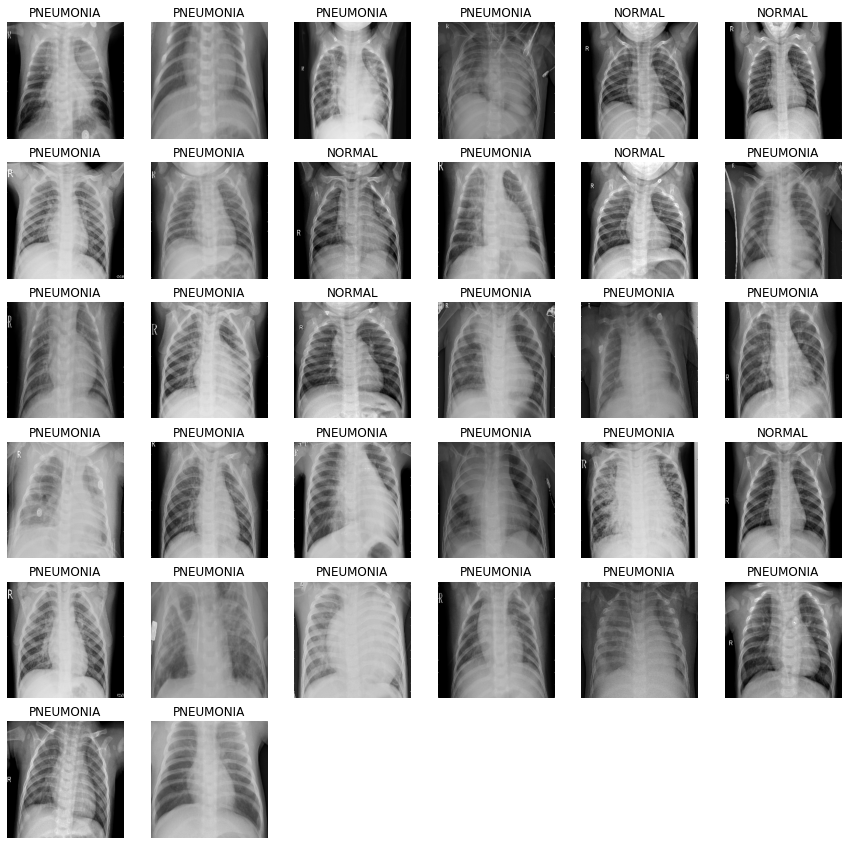

In [3]:
plt.figure(figsize=(15,15))
class_names = train_data.class_names

for images,labels in train_data.take(2):
    for i in range(32):
        ax=plt.subplot(6,6,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<h1 id="aazzz" style="color:white;background:#0087B6;padding:8px;border-radius:8px">  Data augmentation layer</h1>

Looking at the images I feel adding RandomFlip and Random Zoom (Zoom-in) may improve the score

In [4]:
data_augmentation = tf.keras.Sequential([
    
    # RandomFlip layer
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    
    # RandomZoom layer
    tf.keras.layers.experimental.preprocessing.RandomZoom(
        (-0.1,-0.3),
        width_factor=None,
        fill_mode='nearest',
        interpolation='bilinear',
        seed=None,
        fill_value=0.0
  )
])

<h1 id="aazzzz" style="color:white;background:#0087B6;padding:8px;border-radius:8px">  Examples of an augmented image </h1>

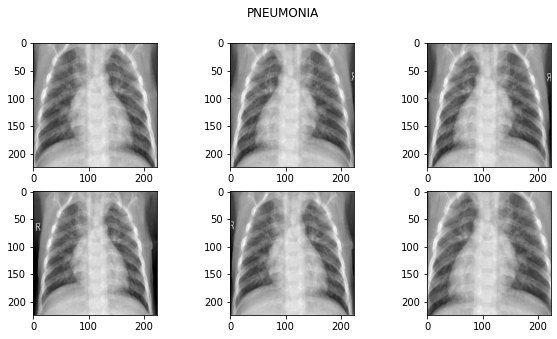

In [5]:
# Run to augment and visualize random image
for image, label in train_data.take(1):
    plt.figure(figsize=(10,5))
    plt.suptitle(class_names[label[0]])
    first_image = image[0]    
    for i in range(6):
        ax= plt.subplot(2,3,i+1)
        augmented_img = data_augmentation(tf.expand_dims(first_image,0))
        plt.imshow(augmented_img[0]/255)

<h1 id="aazzcc" style="color:white;background:#0087B6;padding:8px;border-radius:8px">  Prefetching </h1>

Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)

<h1 id="aazzza" style="color:white;background:#0087B6;padding:8px;border-radius:8px">  Calculate class weights</h1>

The dataset is highly imbalanced and we have to calculate weights for each class Then We can set the class weight when fitting the model

In [7]:
labels = []

for x, y in train_data:   
    labels.append(y.numpy())

labels = np.concatenate(labels, axis = 0) 

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_0 = (1 / len(labels[labels==0]))*(len(labels))/2.0 
weight_1 = (1 / len(labels[labels==1]))*(len(labels))/2.0

print('There are', len(labels[labels==1]),' pneumonia samples and'
      ,len(labels[labels==0]) ,'normal samples')

class_weight = {1: weight_1, 0: weight_0}
print('Weights: ',class_weight)

There are 3102  pneumonia samples and 1071 normal samples
Weights:  {1: 0.6726305609284333, 0: 1.9481792717086837}


<h1 id="aazvbdfg" style="color:white;background:#0087B6;padding:8px;border-radius:8px">  Modeling</h1>

## Callbacks

In [8]:
# Checkpoint path
CheckpointPath="ResNet152.h5"

CheckPointCallback = tf.keras.callbacks.ModelCheckpoint(filepath=CheckpointPath,
                                                        verbose=1,
                                                        save_best_only=True,
                                                        monitor="val_accuracy",
                                                        period=1)

LearningRateReduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                             patience=3,
                                                             verbose=1,
                                                             factor=0.5,
                                                             mode='auto',
                                                             cooldown=1)

EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  min_delta=0.001,
                                                  patience=3,
                                                  verbose=1,
                                                  restore_best_weights=True)

## Base model : ResNet152

In [9]:
base_model = tf.keras.applications.ResNet152(include_top=False)

base_model.trainable = False 

inputs= tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

x = data_augmentation(inputs)

x = base_model(inputs)

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(1 , name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),steps_per_execution = 50,
      metrics=['accuracy'])

234708992/234698864 [==============================] - 5s 0us/step


## Fitting the model

In [10]:
history = model.fit(train_data,
                    epochs=20,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data),
                    callbacks=[ CheckPointCallback,
                                LearningRateReduction,
                                EarlyStopping ],
                    class_weight = class_weight,
                    )

Epoch 1/20
131/131 [==============================] - 71s 544ms/step - loss: 0.5450 - accuracy: 0.6216 - val_loss: 0.3584 - val_accuracy: 0.8044

Epoch 00001: val_accuracy improved from -inf to 0.80441, saving model to ResNet152.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
131/131 [==============================] - 35s 268ms/step - loss: 0.3204 - accuracy: 0.8251 - val_loss: 0.2737 - val_accuracy: 0.8600

Epoch 00002: val_accuracy improved from 0.80441 to 0.86002, saving model to ResNet152.h5
Epoch 3/20
131/131 [==============================] - 34s 262ms/step - loss: 0.2561 - accuracy: 0.8660 - val_loss: 0.2460 - val_accuracy: 0.8754

Epoch 00003: val_accuracy improved from 0.86002 to 0.87536, saving model to ResNet152.h5
Epoch 4/20
131/131 [==============================] - 35s 264ms/step - loss: 0.2175 - accuracy: 0.8852 - val_loss: 0.2145 - val_accuracy: 0.8974

Epoch 00004: val_accuracy improved from 0.87536 to 0.89741, saving model to ResNet152.h5
Epoch 5/20
131/131 [==============================] - 35s 264ms/step - loss: 0.2061 - accuracy: 0.8974 - val_loss: 0.1975 - val_accuracy: 0.9118

Epoch 00005: val_accuracy improved from 0.89741 to 0.91179, saving model to ResNet152.h5
Epoch 6/20
131/131 [==============================] - 35s 26

## Loss curves

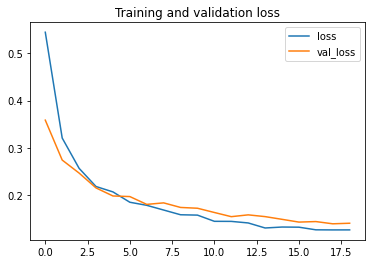

In [11]:
pd.DataFrame(history.history)[['loss','val_loss']].plot(title='Training and validation loss');

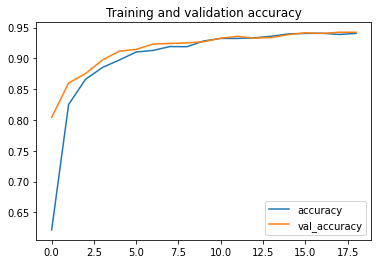

In [12]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(title='Training and validation accuracy');

## Evaluate the model on unseen test data

In [13]:
model.evaluate(test_data)

20/20 [==============================] - 6s 280ms/step - loss: 0.3728 - accuracy: 0.8766


[0.372790664434433, 0.8766025900840759]

### Still working on it ...

### [Take a look at my other notebooks here](https://www.kaggle.com/mehrdadsadeghi/code) and leave your helpful feedbacks <3